# Zero Shot Learning (ZSL)

In [1]:
import pandas as pd
import flair
import re
from flair.models import SequenceTagger
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("data/books_def_small.csv")

In [55]:
df.head()

,book_authors,book_desc,book_rating,book_title,genres
0,Suzanne Collins,Winning will make you famous. Losing means cer...,4.33,The Hunger Games,Young Adult
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,4.48,Harry Potter and the Order of the Phoenix,Fantasy
2,Harper Lee,The unforgettable novel of a childhood in a sl...,4.27,To Kill a Mockingbird,Classics
3,Stephenie Meyer,About three things I was absolutely positive.F...,3.58,Twilight,Young Adult
4,Markus Zusak,Trying to make sense of the horrors of World W...,4.36,The Book Thief,Historical


In [56]:
print(df.shape)


(26484, 5)


In [57]:
df.book_desc = df.book_desc.astype(str)
df.genres = df.genres.astype(str)

In [58]:
#genre subsets
df_gb = [x for _, x in df.groupby('genres')]
df_fantasy = df_gb[1].copy()
df_mistery = df_gb[4].copy()
df_scifi = df_gb[7].copy()
df_romance = df_gb[6].copy()


In [62]:
genre = ["Fantasy", "Science Fiction", "Mystery", "Romance"]

In [64]:
df_pred_genres = df_mistery.copy()
df_pred_genres

,book_authors,book_desc,book_rating,book_title,genres
96,Agatha Christie,"First, there were ten—a curious assortment of ...",4.25,And Then There Were None,Mystery
192,Agatha Christie,"En route to London, Belgian detective Hercule ...",4.16,Murder on the Orient Express,Mystery
507,Ellen Raskin,A bizarre chain of events begins when sixteen ...,4.03,The Westing Game,Mystery
533,Janet Evanovich,"Pestered by her close New Jersey family, Steph...",4.03,One for the Money,Mystery
559,Alexander McCall Smith,Precious Ramotswe has only just set up shop as...,3.77,The No. 1 Ladies' Detective Agency,Mystery
...,...,...,...,...,...
26358,April Henry,In this new series told from multiple perspect...,3.83,The Body in the Woods,Mystery
26359,James Lee Burke,A routine assignment transporting two death-ro...,4.16,A Morning for Flamingos,Mystery
26368,Charlaine Harris,"Welcome to Shakespeare, Arkansas. Lily Bard ca...",3.76,Shakespeare's Landlord,Mystery
26393,Carolyn Keene,Nancy and her friends witness an explosion and...,3.94,The Clue in the Diary,Mystery


### Genre prediction

In [60]:
from flair.models import TARSClassifier
from flair.data import Sentence

In [61]:
# TARS: Task-aware representation of sentences
tars = TARSClassifier.load('tars-base')
existing_tasks = tars.list_existing_tasks()
existing_tasks

2022-06-04 15:26:15,896 loading file C:\Users\Erica\.flair\models\tars-base-v8.pt


{'AGNews',
 'Amazon',
 'DBPedia',
 'GO_EMOTIONS',
 'IMDB',
 'NEWS_CATEGORY',
 'SST',
 'TREC_6',
 'Yelp'}

In [16]:
def genre_tagger(summary, genre, tars):
    s = Sentence(summary)
    tars.predict_zero_shot(s, genre, multi_label=True)
    dict_tag = {}
    
    for label in s.labels:
        dict_tag[label.value] = label.score
        print (label)
    sorted_tag = sorted(dict_tag, key=dict_tag.get, reverse=True)[:3]
    
    return [sorted_tag[0], sorted_tag[1],sorted_tag[2]]

In [17]:
df_pred_genres['tag_1'], df_pred_genres['tag_2'], df_pred_genres['tag_3'] = zip(*df_pred_genres["book_desc"].apply(lambda x: genre_tagger(x, genre, tars)))

IndexError: list index out of range

### Another ZSL model

In [65]:
import torch
torch.cuda.is_available()

False

In [66]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")


In [67]:
def genre_tagger_transformer(summary, genre, classifier):
    genres = classifier(summary, genre)["labels"]
    return [genres[0], genres[1],genres[2]]

In [68]:
df_pred_genres['tag_1'], df_pred_genres['tag_2'], df_pred_genres['tag_3'] = zip(*df_pred_genres["book_desc"].apply(lambda x: genre_tagger_transformer(x, genre, classifier)))

In [69]:
df_pred_genres.to_csv("data/ZSL_mistery.csv")

### Results analysis

In [193]:
df_scifi = pd.read_csv("data/ZSL_scifi.csv", index_col = 0)
df_mystery = pd.read_csv("data/ZSL_mystery.csv", index_col = 0)

In [194]:
df_matrix = df_mystery.append(df_scifi)

<ipython-input-194-82ca054257f8>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_matrix = df_mystery.append(df_scifi)


In [195]:
df_mystery

,book_authors,book_desc,book_rating,book_title,genres,tag_1,tag_2,tag_3
96,Agatha Christie,"First, there were ten—a curious assortment of ...",4.25,And Then There Were None,Mystery,Mystery,Romance,Sci-fi
192,Agatha Christie,"En route to London, Belgian detective Hercule ...",4.16,Murder on the Orient Express,Mystery,Romance,Mistery,Fantasy
507,Ellen Raskin,A bizarre chain of events begins when sixteen ...,4.03,The Westing Game,Mystery,Mystery,Fantasy,Sci-fi
533,Janet Evanovich,"Pestered by her close New Jersey family, Steph...",4.03,One for the Money,Mystery,Mystery,Romance,Fantasy
559,Alexander McCall Smith,Precious Ramotswe has only just set up shop as...,3.77,The No. 1 Ladies' Detective Agency,Mystery,Mystery,Romance,Fantasy
...,...,...,...,...,...,...,...,...
26358,April Henry,In this new series told from multiple perspect...,3.83,The Body in the Woods,Mystery,Mystery,Romance,Sci-fi
26359,James Lee Burke,A routine assignment transporting two death-ro...,4.16,A Morning for Flamingos,Mystery,Mystery,Fantasy,Sci-fi
26368,Charlaine Harris,"Welcome to Shakespeare, Arkansas. Lily Bard ca...",3.76,Shakespeare's Landlord,Mystery,Romance,Mistery,Fantasy
26393,Carolyn Keene,Nancy and her friends witness an explosion and...,3.94,The Clue in the Diary,Mystery,Mystery,Romance,Fantasy


In [181]:
# we filter only on the column with Mystery or Scifi as first genre
# used to plot a 2-label CM
genre_tags = ["Mystery", "Science Fiction"]
df_matrix = df_matrix.loc[df_matrix['tag_1'].isin(genre_tags)]


In [196]:
df_matrix

,book_authors,book_desc,book_rating,book_title,genres,tag_1,tag_2,tag_3
96,Agatha Christie,"First, there were ten—a curious assortment of ...",4.25,And Then There Were None,Mystery,Mystery,Romance,Sci-fi
192,Agatha Christie,"En route to London, Belgian detective Hercule ...",4.16,Murder on the Orient Express,Mystery,Romance,Mistery,Fantasy
507,Ellen Raskin,A bizarre chain of events begins when sixteen ...,4.03,The Westing Game,Mystery,Mystery,Fantasy,Sci-fi
533,Janet Evanovich,"Pestered by her close New Jersey family, Steph...",4.03,One for the Money,Mystery,Mystery,Romance,Fantasy
559,Alexander McCall Smith,Precious Ramotswe has only just set up shop as...,3.77,The No. 1 Ladies' Detective Agency,Mystery,Mystery,Romance,Fantasy
...,...,...,...,...,...,...,...,...
26411,Paul Melko,\r\n\r\nPossessing technology that allows him ...,3.68,Broken Universe,Science Fiction,Romance,Mistery,Sci-fi
26417,Adam Roberts,The Universe's first mass murderer for thousan...,3.68,Stone,Science Fiction,Science Fiction,Fantasy,Mistery
26421,Stephen R. Donaldson,"A master storyteller, Stephen R. Donaldson est...",4.08,The Gap Into Power: A Dark and Hungry God Arises,Science Fiction,Science Fiction,Mistery,Fantasy
26426,Michael Swanwick,"Among the vanguard of today's boldest writers,...",3.83,Vacuum Flowers,Science Fiction,Science Fiction,Fantasy,Mistery


In [197]:
y_test = df_matrix.genres.to_list()
y_pred = df_matrix.tag_1.to_list()

In [201]:
print(set(y_pred))
print(set(y_test))

{'Romance', 'Mystery', 'Science Fiction', 'Fantasy'}
{'Mystery', 'Science Fiction'}


In [199]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

In [200]:
print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred, )
print(cm)

Classification report:
                 precision    recall  f1-score   support

        Fantasy       0.00      0.00      0.00         0
        Mystery       0.82      0.71      0.76      1793
        Romance       0.00      0.00      0.00         0
Science Fiction       0.90      0.65      0.75      1479

       accuracy                           0.68      3272
      macro avg       0.43      0.34      0.38      3272
   weighted avg       0.86      0.68      0.76      3272

Confusion matrix:
[[   0    0    0    0]
 [  80 1269  341  103]
 [   0    0    0    0]
 [  74  280  166  959]]


C:\Users\Erica\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


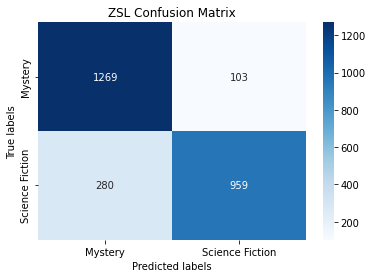

In [188]:
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Blues"); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('ZSL Confusion Matrix'); 
ax.xaxis.set_ticklabels(genre_tags); ax.yaxis.set_ticklabels(genre_tags);

# NER

In [13]:
tagger = SequenceTagger.load('ner')

2022-06-02 08:17:07,435 loading file C:\Users\Erica\.flair\models\ner-english\4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-06-02 08:17:09,884 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [14]:
def ner_extraction(summary): 
    sentence = Sentence(summary)
    tagger.predict(sentence)
    misc = []
    loc = []
    org = []
    per = []
    for label in sentence.get_labels('ner'):
        if label.value == "MISC": 
            misc.append(label.data_point.text)
        elif label.value == "LOC":
            loc.append(label.data_point.text)
        elif label.value == "ORG":
            org.append(label.data_point.text)
        elif label.value == "PER":
            per.append(label.data_point.text)
    return [misc, loc, org, per]

In [22]:
df_mistery['MISC'], df_mistery['LOC'], df_mistery['ORG'], df_mistery["PER"] = zip(*df_mistery["book_desc"].apply(lambda x: ner_extraction(x)))

In [23]:
df_mistery

,book_authors,book_desc,book_rating,book_title,genres,MISC,LOC,ORG,PER
96,Agatha Christie,"First, there were ten—a curious assortment of ...",4.25,And Then There Were None,Mystery,[],[Devon],[],[]
192,Agatha Christie,"En route to London, Belgian detective Hercule ...",4.16,Murder on the Orient Express,Mystery,"[Belgian, American]","[London, Calais]",[Orient Express],"[Hercule Poirot, Poirot]"
507,Ellen Raskin,A bizarre chain of events begins when sixteen ...,4.03,The Westing Game,Mystery,[],[],[],"[Samuel W. Westing, Sam Westing]"
533,Janet Evanovich,"Pestered by her close New Jersey family, Steph...",4.03,One for the Money,Mystery,[],[New Jersey],[],"[Stephanie Plum, Joe Morelli, Vinnie, Benito R..."
559,Alexander McCall Smith,Precious Ramotswe has only just set up shop as...,3.77,The No. 1 Ladies' Detective Agency,Mystery,[],[Botswana],[],[Precious Ramotswe]
...,...,...,...,...,...,...,...,...,...
26358,April Henry,In this new series told from multiple perspect...,3.83,The Body in the Woods,Mystery,[Henry ’s Point Last Seen YA],[],[Portland County Sheriff ’s Search and Rescue],"[Nick, Ruby, Alexis, Nick, Ruby]"
26359,James Lee Burke,A routine assignment transporting two death-ro...,4.16,A Morning for Flamingos,Mystery,[Cajun],[New Orleans],[DEA],"[Dave Robicheaux, Dave, Tony Cardo]"
26368,Charlaine Harris,"Welcome to Shakespeare, Arkansas. Lily Bard ca...",3.76,Shakespeare's Landlord,Mystery,"[Shakespeare.Shakespeare's Landlord, Lily Bard]","[Shakespeare, Arkansas, Shakespeare]",[],"[Lily Bard, Lily, Charlaine Harris]"
26393,Carolyn Keene,Nancy and her friends witness an explosion and...,3.94,The Clue in the Diary,Mystery,[],[],[],"[Nancy, Nancy, Nancy, Nancy Drew, Nancy Drew]"


In [24]:
df_mistery.to_csv("data/ner_mistery.csv")

In [34]:
df_scifi['MISC'], df_scifi['LOC'], df_scifi['ORG'], df_scifi["PER"] = zip(*df_scifi["book_desc"].apply(lambda x: ner_extraction(x)))

In [35]:
df_scifi.to_csv("data/ner_scifi.csv")

In [16]:
df_romance['MISC'], df_romance['LOC'], df_romance['ORG'], df_romance["PER"] = zip(*df_romance["book_desc"].apply(lambda x: ner_extraction(x)))

In [17]:
df_romance.to_csv("data/ner_romance.csv")

In [18]:
df_fantasy['MISC'], df_fantasy['LOC'], df_fantasy['ORG'], df_fantasy["PER"] = zip(*df_fantasy["book_desc"].apply(lambda x: ner_extraction(x)))

In [19]:
df_fantasy.to_csv("data/ner_fantasy.csv")